In [1]:
!pwd

/home/charlie/ephys-experiments/notebooks


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import dartsort
import numpy as np
import dartsort.vis as dartvis
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA, TruncatedSVD
import spikeinterface.full as si
from dartsort.config import *
from dartsort.cluster import initial, density
import dataclasses
from dartsort.util import drift_util, data_util
import warnings
from tqdm.auto import trange, tqdm
from scipy.stats import chi2
from ephysx import spike_gmm, spike_lrgmm, spike_basic, ppca
from matplotlib import colors
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from dredge import motion_util

In [4]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import offset_copy
from matplotlib.patches import Ellipse, Rectangle, ConnectionPatch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
import contextlib
import colorcet as cc

plt.rc("figure", dpi=300)
plt.rc("figure", figsize=(2, 2))
SMALL_SIZE = 5
MEDIUM_SIZE = 7
BIGGER_SIZE =  8
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [5]:
# global
model_radius = 15.0
cfg = DARTsortConfig(
    matching_iterations=2,
    subtraction_config=SubtractionConfig(
        detection_thresholds=(12, 9, 6, 5),
        extract_radius=75.0,
        max_waveforms_fit=20_000,
        subtraction_denoising_config=FeaturizationConfig(
            denoise_only=True,
            input_waveforms_name="raw",
            output_waveforms_name="subtracted",
            tpca_fit_radius=model_radius,
            tpca_centered=False,
        ),
        residnorm_decrease_threshold=20.0,
    ),
    matching_config=MatchingConfig(
        threshold=2500.0,
        max_waveforms_fit=20_000,
        extract_radius=75.0,
    ),
    template_config=TemplateConfig(
        denoising_fit_radius=model_radius,
        denoising_snr_threshold=100.0,
        superres_templates=False,
    ),
    clustering_config=ClusteringConfig(
        cluster_strategy="density_peaks",
        sigma_regional=25.0,
        noise_density=1.0,
        ensemble_strategy=None,
    ),
    split_merge_config=SplitMergeConfig(
        min_spatial_cosine=0.0,
        linkage="single",
        # linkage="weighted_template",
        split_strategy_kwargs=dict(
            channel_selection_radius=model_radius,
            max_spikes=10_000,
        ),
        merge_template_config=TemplateConfig(
            denoising_fit_radius=model_radius,
            denoising_snr_threshold=100.0,
            superres_templates=False,
        )
    ),
    featurization_config=FeaturizationConfig(
        tpca_fit_radius=model_radius,
        localization_radius=50.0,
        localization_model="dipole",
        tpca_centered=False,
    ),
    motion_estimation_config=MotionEstimationConfig(
        max_dt_s=1000,
        window_scale_um=250,
        window_step_um=75,
        window_margin_um=-150,
        min_amplitude=15.0,
    ),
)

In [6]:
@contextlib.contextmanager
def subplots(*args, **kwargs):
    fig, axes = plt.subplots(*args, **kwargs)
    try:
        yield fig, axes
    finally:
        plt.show()
        plt.close(fig)

In [7]:
# !ls /home/charlie/data/uhdzigzagzye57cmr_chunk/

In [8]:
# rec_old = si.read_binary_folder("/home/charlie/data/uhdzzzye57cmr_chunk//")

# rec0 = si.read_binary("/home/charlie/data/uhdzzzye57orig_p0_g0_t0.imec0.ap.bin", 30000, np.int16, num_channels=385)
# rec0 = rec0.channel_slice(rec0.channel_ids[:384])
# rec0.set_dummy_probe_from_locations(rec_old.get_channel_locations())

# rec1 = rec0.astype(np.float32)
# rec1 = si.highpass_filter(rec1)
# rec1 = si.common_reference(rec1)
# rec1 = si.zscore(rec1, mode="mean+std", num_chunks_per_segment=100, seed=0)

In [9]:
# rec2 = rec0.astype(np.float32)
# rec2 = si.highpass_filter(rec2)
# rec2 = si.common_reference(rec2, reference="local")
# rec2 = si.zscore(rec2, mode="mean+std", num_chunks_per_segment=100)

In [10]:
# sample_start = rec1.time_to_sample_index(3417.2011076923077, 0)
# sample_end = rec1.time_to_sample_index(3727.8557538461537, 0)

# sample_start, sample_end

# rec1 = rec1.frame_slice(sample_start, sample_end)

# rec1 = rec1.save_to_folder("/home/charlie/data/uhdzzzye57cmr_chunk")
# rec1 = rec1.save_to_folder("/home/charlie/scratch/uhdzzzye57cmr")

# rec1 = si.read_binary_folder("/home/charlie/data/uhdzzzye57cmr_chunk")

# dartsort.subtract(
#     rec1,
#     "/home/charlie/data/uhdzzzye57cmrsub",
#     subtraction_config=cfg.subtraction_config,
#     featurization_config=cfg.featurization_config,
#     overwrite=True,
#     n_jobs=2,
# )

In [7]:
rec1 = si.read_binary_folder("/home/charlie/scratch/uhdzzzye57cmr")

In [8]:
# # using TSVD not TPCA!
# dartsort.subtract(
#     rec1,
#     "/home/charlie/data/uhdzzzye57cmrsub",
#     subtraction_config=cfg.subtraction_config,
#     featurization_config=cfg.featurization_config,
#     overwrite=True,
#     n_jobs=2,
# )

In [9]:
sub_st = dartsort.DARTsortSorting.from_peeling_hdf5('/home/charlie/data/uhdzzzye57cmrsub/subtraction.h5')

In [10]:
motion_est = dartsort.estimate_motion(
    rec1,
    sub_st,
    sub_st.parent_h5_path.parent,
    # overwrite=True,
    **dataclasses.asdict(cfg.motion_estimation_config)
)

In [11]:
full_dpc = initial.cluster_chunk(
    # sub_st.parent_h5_path,
    "/home/charlie/data/uhdzzzye57cmrsub/subtraction.h5",
    cfg.clustering_config,
    # chunk_time_range_s=chunk_time_ranges[10],
    motion_est=motion_est,
)

In [12]:
ref_clust = full_dpc

In [13]:
full_dpc

DARTsortSorting: 553473 spikes, 85 units. extra features: point_source_localizations, denoised_ptp_amplitudes, times_seconds. from parent h5 file /home/charlie/data/uhdzzzye57cmrsub/subtraction.h5.

In [21]:
# chunk_time_ranges_s, chunk_dpcs = initial.cluster_chunks(
#     sub_st.parent_h5_path,
#     rec1,
#     dataclasses.replace(
#         cfg.clustering_config,
#         ensemble_strategy="manual",
#     ),
#     motion_est=motion_est,
# )

In [22]:
# _, _, chunk_dpc_combine = data_util.combine_sortings(chunk_dpcs, dodge=True)

In [23]:
# chunk_dpc_combine

In [14]:
rec = rec1

In [30]:
ref_clust = full_dpc
analysis_tcfg = dartsort.TemplateConfig(superres_templates=False, realign_peaks=False, denoising_snr_threshold=100.0, denoising_fit_radius=25.0)
analysis_tpca = None
def get_analysis(labels, keepers=None, base_sorting=None):
    if base_sorting is None:
        base_sorting=ref_clust
    global analysis_tpca
    if analysis_tpca is None:
        analysis_tpca = dartsort.templates.get_templates.fit_tsvd(rec, base_sorting)

    if keepers is not None:
        labels_ = np.full_like(base_sorting.labels, -1)
        labels_[keepers] = labels
        labels = labels_
    sorting = dataclasses.replace(
        base_sorting,
        labels=labels,
    )
    return dartsort.DARTsortAnalysis.from_sorting(
        rec,
        sorting,
        motion_est=motion_est,
        allow_template_reload=False,
        template_config=analysis_tcfg,
        denoising_tsvd=analysis_tpca,
        device="cpu",
    )

merge_centroid_only = False
def makeplots(i, subdir, gmm=None, sorting=None, n_jobs=0, with_summaries=True, with_dpcs=True, with_over_time=False, overwrite=False):
    global analysis_tpca
    if gmm is None:
        a0 = get_analysis(sorting.labels, base_sorting=sorting)
    else:
        a0 = get_analysis(gmm.labels, gmm.data.keepers)

    print("scatters...")
    if overwrite or not (subdir / "sorting.png").exists():
        fig = plt.figure(figsize=(15, 15))
        fig = dartvis.make_sorting_summary(a0, figure=fig);
        fig.savefig(subdir / "sorting.png", dpi=200)
        plt.close(fig)

    if overwrite or not (subdir / "scatter.png").exists():
        fig = plt.figure(figsize=(15, 15))
        fig, ax, ss = dartvis.scatter_spike_features(sorting=a0.sorting, show_triaged=False, figure=fig, width_ratios=[1, 1, 1]);
        motion_util.plot_me_traces(motion_est, ax=ax[-1], color="r", lw=1)
        fig.savefig(subdir / "scatter.png", dpi=200)
        plt.close(fig)

    if overwrite or not (subdir / "scatter_reg.png").exists():
        fig = plt.figure(figsize=(15, 15))
        fig, ax, ss = dartvis.scatter_spike_features(
            sorting=a0.sorting, motion_est=motion_est, registered=True, show_triaged=False, figure=fig, width_ratios=[1, 1, 1]
        );
        fig.savefig(subdir / "scatter_reg.png", dpi=200)
        plt.close(fig)

    if overwrite or not (subdir / "unsorted_scatter.png").exists():
        fig = plt.figure(figsize=(15, 15))
        fig, ax, ss = dartvis.scatter_spike_features(sorting=sub_st, show_triaged=False, figure=fig, width_ratios=[1, 1, 1]);
        motion_util.plot_me_traces(motion_est, ax=ax[-1], color="r", lw=1)
        fig.savefig(subdir / "unsorted_scatter.png", dpi=200)
        plt.close(fig)

    if overwrite or not (subdir / "unsorted_scatter_reg.png").exists():
        fig = plt.figure(figsize=(15, 15))
        fig, ax, ss = dartvis.scatter_spike_features(
            sorting=sub_st, motion_est=motion_est, registered=True, show_triaged=False, figure=fig, width_ratios=[1, 1, 1]
        );
        fig.savefig(subdir / "unsorted_scatter_reg.png", dpi=200)
        plt.close(fig)

    if overwrite or not (subdir / "unsortedrainbow_scatter.png").exists():
        fig = plt.figure(figsize=(6, 4))
        fig, ax, ss = dartvis.scatter_spike_features(sorting=sub_st, show_triaged=False, figure=fig, width_ratios=[1, 1, 1], amplitude_cmap=plt.cm.rainbow, amplitude_color_cutoff=50, semilog_amplitudes=False);
        motion_util.plot_me_traces(motion_est, ax=ax[-1], color="r", lw=1)
        fig.savefig(subdir / "unsortedrainbow_scatter.png", dpi=200)
        plt.close(fig)

    if overwrite or not (subdir / "unsortedrainbow_scatter_reg.png").exists():
        fig = plt.figure(figsize=(6, 4))
        fig, ax, ss = dartvis.scatter_spike_features(
            sorting=sub_st, motion_est=motion_est, registered=True, show_triaged=False, figure=fig, width_ratios=[1, 1, 1], amplitude_cmap=plt.cm.rainbow, amplitude_color_cutoff=50, semilog_amplitudes=False
        );
        fig.savefig(subdir / "unsortedrainbow_scatter_reg.png", dpi=200)
        plt.close(fig)

    print(f"{gmm=}")
    if gmm is not None:
        if overwrite or not (subdir / "dists.png").exists():
            fig, ax = plt.subplots(figsize=(8, 8))
            # fig, ax, ss = dartvis.scatter_spike_features(
            #     sorting=a0.sorting, motion_est=motion_est, registered=True, show_triaged=False, figure=fig, width_ratios=[1, 1, 1]
            # );
            dist_res = gmm.centroid_dists(centroid_only=merge_centroid_only)
            im = ax.imshow(dist_res["unexplained_var"], interpolation="none", vmin=0, vmax=1, cmap=plt.cm.rainbow)
            plt.colorbar(im, ax=ax, shrink=0.5)
            fig.savefig(subdir / "dists.png", dpi=200)
            plt.close(fig)
    
        if overwrite or not (subdir / "likdists.png").exists():
            fig, ax = plt.subplots(figsize=(8, 8))
            # fig, ax, ss = dartvis.scatter_spike_features(
            #     sorting=a0.sorting, motion_est=motion_est, registered=True, show_triaged=False, figure=fig, width_ratios=[1, 1, 1]
            # );
            dist_res = gmm.centroid_dists(kind="likelihood", centroid_only=merge_centroid_only)
            im = ax.imshow(dist_res["logliks"], interpolation="none", cmap=plt.cm.rainbow)
            plt.colorbar(im, ax=ax, shrink=0.5)
            fig.savefig(subdir / "likdists.png", dpi=200)
            plt.close(fig)

    if overwrite or not (subdir / "scatter_regt.png").exists():
        fig = plt.figure(figsize=(15, 15))
        fig, ax, ss = dartvis.scatter_spike_features(
            sorting=a0.sorting, motion_est=motion_est, registered=True, show_triaged=True, figure=fig, width_ratios=[1, 1, 1]
        );
        fig.savefig(subdir / "scatter_regt.png", dpi=200)
        plt.close(fig)
    print("scatters done")
        
    if with_over_time:
        print("animation")
        if overwrite or not (subdir / f"animation.mp4").exists():
            dartvis.sorting_scatter_animation(
                    a0,
                    subdir / f"animation.mp4",
                    chunk_length_samples=300 * rec.sampling_frequency,
                    device="cpu",
                    templates_tsvd=analysis_tpca,
                )
        print("animation done")
    
    print("over_time")
    if with_over_time and (overwrite or not (subdir / "over_time" / f"unit{a0.coarse_template_data.unit_ids.max():04d}.png").exists()):
        dartvis.make_all_over_time_summaries(
            a0,
            subdir / "over_time",
            chunk_length_s=300.0,
            channel_show_radius_um=15.0,
            amplitude_color_cutoff=25.0,
            pca_radius_um=25.0,
            # max_height=18,
            figsize=(20, 20),
            dpi=150,
            image_ext="png",
            n_jobs=n_jobs,
            n_jobs_templates=0,
            show_progress=True,
            overwrite=overwrite,
            analysis_kw=dict(device="cpu"),
        )
    print("over_time done")

    print("dpcs")
    if with_dpcs and gmm is not None:
        if overwrite or not (subdir / "dens" / f"{gmm.unit_ids()[-1]:04d}.png").exists():
            (subdir / "dens").mkdir(exist_ok=True)
            for uid in tqdm(gmm.unit_ids()):
                try:
                    z = gmm.train_loadings[uid]
                    in_unit = gmm.train_spike_indices[uid]
                    valid = np.flatnonzero(in_unit >= 0)
                    in_unit = in_unit[valid]
                    z = z[valid, :2]
                    dens = density.density_peaks_clustering(
                        z[:, :2],
                        sigma_local="rule_of_thumb",
                        # sigma_regional="rule_of_thumb",
                        n_neighbors_search=500,
                        return_extra=True,
                    )
                    if "density" not in dens:
                        print("Clustering threw everyone away")
                        continue
                    ru = np.unique(dens["labels"])
                    fig, axes = dartvis.analysis_plots.density_peaks_study(z, dens, s=10)
                    fig.savefig(subdir / "dens" / f"{uid:04d}.png", dpi=200)
                    plt.close(fig)
                except ValueError as e:
                    print(e)
                finally:
                    plt.close("all")
    print("dpcs done")

    print("summaries")
    if with_summaries:
        dartvis.make_all_summaries(
            a0,
            subdir / "summaries",
            channel_show_radius_um=15,
            pca_radius_um=25.0,
            overwrite=overwrite,
            n_jobs=n_jobs,
            dpi=150,
        )
    print("summaries done")



In [16]:
merge_centroid_only = False

In [18]:
figdir = Path("~/data/uhdclustfigs").expanduser()
figdir.mkdir(exist_ok=True)

In [31]:
subdir = figdir / f"0000_full_dpc"
subdir.mkdir(exist_ok=True)
makeplots(0, subdir, sorting=full_dpc, n_jobs=4, with_summaries=True, with_dpcs=True, overwrite=True)

Denoised templates:   0%|          | 0/85 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/121 [00:00<?, ?pair block/s]

scatters...
gmm=None
scatters done
over_time
over_time done
dpcs
dpcs done
summaries


Unit summaries:   0%|          | 0/85 [00:00<?, ?it/s]

summaries done


In [30]:
plot_njobs = 0

In [32]:
1

1

In [35]:
run_name = "zzztv_a_01"
merge_threshold = 0.25
merge_link = "complete"
merge_centroid_only = True
reassign_centroid_only = True
n_split_retries = 1
n_merge_retries = 5

In [36]:
gmm = spike_basic.BasicSpikePCAClusterer(
    # chunk_dpc_combine,
    full_dpc,
    motion_est=motion_est,
    centered=True,
    rank=2,
    in_memory=True,
    fit_radius=15.0,
    wf_radius=10.0,
    whiten_input=False,
    spike_r2_threshold=0.25,
    embedding_damping=5.0,
    n_wfs_fit=4096,
    split_rank=2,
    reassign_rank=0,
    merge_rank=0,
    split_impute_iters=0,
    reassign_impute_iters=0,
)

gmm.cuda()

0.0% in 7 too-small units


BasicSpikePCAClusterer()

In [37]:
mco = "y" if merge_centroid_only else "n"
rco = "y" if reassign_centroid_only else "n"
sot = "y" if gmm.split_on_train else "n"
run_name = f"{run_name}_r{gmm.rank}_{merge_link}{merge_threshold}_mco{mco}_rco{rco}_srs{gmm.spike_r2_threshold}_sot{sot}"

In [38]:
gmm.m_step()

Fit:   0%|          | 0/78 [00:00<?, ?it/s]

In [39]:
gmm.dpc_split()

Split round 1:   0%|          | 0/78 [00:00<?, ?it/s]

Fit:   0%|          | 0/88 [00:00<?, ?it/s]

Split round 2:   0%|          | 0/26 [00:00<?, ?it/s]

Fit:   0%|          | 0/24 [00:00<?, ?it/s]

Split round 3:   0%|          | 0/2 [00:00<?, ?it/s]

Fit:   0%|          | 0/2 [00:00<?, ?it/s]

Split: 78 -> 92


In [40]:
gmm.reassign(centroid_only=reassign_centroid_only)
gmm.m_step()

Unit distances:   0%|          | 0/92 [00:00<?, ?it/s]

7.4% of spikes unmatched after reassignment.


Fit:   0%|          | 0/92 [00:00<?, ?it/s]

In [41]:
gmm.drop_small()

In [42]:
figdir

PosixPath('/home/charlie/data/uhdclustfigs')

In [44]:
plot_njobs = 0

In [45]:
subdir = figdir / f"{run_name}_00_splitreas"
subdir.mkdir(exist_ok=True)
makeplots(0, subdir, gmm, n_jobs=plot_njobs, with_summaries=True, with_dpcs=False, with_over_time=False)


Denoised templates:   0%|          | 0/92 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/144 [00:00<?, ?pair block/s]

scatters...
gmm=BasicSpikePCAClusterer()
scatters done
over_time
over_time done
dpcs
dpcs done
summaries


Unit summaries:   0%|          | 0/92 [00:00<?, ?it/s]

summaries done


In [46]:
retry = 0
n_retries = 3

In [ ]:
for retry in range(retry, n_retries):
    print(f"{retry=}")
    gmm.dpc_split()
    
    doplot = True
    doot = retry + 1 == n_retries
    
    if doplot:
        subdir = figdir / f"{run_name}_{retry}_asplit"
        subdir.mkdir(exist_ok=True)
        makeplots(0, subdir, gmm, n_jobs=plot_njobs, with_summaries=True, with_dpcs=True, with_over_time=False)

    gmm.reassign(centroid_only=reassign_centroid_only)
    gmm.m_step()

    if doplot:
        subdir = figdir / f"{run_name}_{retry}_bsplitreas"
        subdir.mkdir(exist_ok=True)
        makeplots(0, subdir, gmm, n_jobs=plot_njobs, with_summaries=True, with_dpcs=True, with_over_time=doot)

    nu = gmm.unit_ids().size
    for j in range(n_merge_retries):
        gmm.merge(threshold=merge_threshold, link=merge_link, centroid_only=merge_centroid_only)
        gmm.m_step()
        nun = gmm.unit_ids().size
        if nun == nu:
            break
        nu = nun

    # subdir = figdir / f"{run_name}_{retry}_cmerge"
    # subdir.mkdir(exist_ok=True)
    # makeplots(0, subdir, gmm, n_jobs=plot_njobs, with_summaries=False, with_dpcs=False)

    gmm.reassign(centroid_only=reassign_centroid_only)
    gmm.m_step()

    if doplot:
        subdir = figdir / f"{run_name}_{retry}_dmergereas"
        subdir.mkdir(exist_ok=True)
        makeplots(0, subdir, gmm, n_jobs=plot_njobs, with_summaries=True, with_dpcs=True, with_over_time=doot)

retry=0


Split round 1:   0%|          | 0/92 [00:00<?, ?it/s]

Fit:   0%|          | 0/103 [00:00<?, ?it/s]

Split round 2:   0%|          | 0/21 [00:00<?, ?it/s]

Fit:   0%|          | 0/20 [00:00<?, ?it/s]

Split round 3:   0%|          | 0/4 [00:00<?, ?it/s]

Fit:   0%|          | 0/5 [00:00<?, ?it/s]

Split round 4:   0%|          | 0/2 [00:00<?, ?it/s]

Fit:   0%|          | 0/2 [00:00<?, ?it/s]

Split: 92 -> 105


Denoised templates:   0%|          | 0/105 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/196 [00:00<?, ?pair block/s]

scatters...
gmm=BasicSpikePCAClusterer()
scatters done
over_time
over_time done
dpcs


  0%|          | 0/105 [00:00<?, ?it/s]

dpcs done
summaries


Unit summaries:   0%|          | 0/105 [00:00<?, ?it/s]

summaries done


Unit distances:   0%|          | 0/105 [00:00<?, ?it/s]

7.0% of spikes unmatched after reassignment.


Fit:   0%|          | 0/105 [00:00<?, ?it/s]

Denoised templates:   0%|          | 0/105 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/196 [00:00<?, ?pair block/s]

scatters...
gmm=BasicSpikePCAClusterer()
scatters done
over_time
over_time done
dpcs


  0%|          | 0/105 [00:00<?, ?it/s]

dpcs done
summaries


Unit summaries:   0%|          | 0/105 [00:00<?, ?it/s]

In [37]:
gmm.m_step()

Fit:   0%|          | 0/94 [00:00<?, ?it/s]

In [38]:
uid = 60

In [39]:
X, missing, empty, inds, n_wfs_fit, channel_had_observations = gmm.get_training_data(np.array([uid]))

In [40]:
t = sub_st.times_seconds[inds]

In [41]:
chans = t = sub_st.channels[inds]

In [42]:
X = X[0]

In [46]:
import gpytorch

In [47]:
X

tensor([[   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [   nan,    nan, 8.5212,  ...,    nan,    nan,    nan],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan]],
       device='cuda:0')

In [48]:
X.shape

torch.Size([4096, 168])

In [260]:
t

array([[   6.983     ,    9.39473333,   10.73796667, ..., 4022.9107    ,
        4022.9511    , 4025.3798    ]])

In [261]:
t.shape

(1, 4096)

In [44]:
t = torch.tensor(t[0])

In [45]:
t = t.to(torch.float)

In [46]:
t

tensor([157., 173., 165.,  ..., 317., 317., 318.])

In [47]:
train_x = t[:, None]
# train_y = X

In [48]:
t

tensor([157., 173., 165.,  ..., 317., 317., 318.])

In [113]:
from sklearn.gaussian_process.kernels import RBF

class SlowGPFA(torch.nn.Module):
    
    def __init__(self, t_min, t_max, output_dim, bandwidth, rank=1, dt=5.0, seed=0):
        super().__init__()
        rg = np.random.default_rng(seed)
        self.t_min = t_min
        self.t_max = t_max
        self.rank = rank
        self.bandwidth = bandwidth
        self.register_buffer(
            "inducing_times",
            torch.linspace(
                torch.tensor(t_min),
                torch.tensor(t_max),
                int(np.ceil((t_max - t_min) / dt)),
            ),
        )
        self.dt = torch.diff(self.inducing_times).mean()
        self.ni = len(self.inducing_times)
        self.register_parameter(
            "inducing_z",
            torch.nn.Parameter(
                torch.tensor(rg.normal(size=(self.ni, rank)), dtype=torch.float)
            ),
        )
        self.register_parameter(
            "obs_logstd",
            torch.nn.Parameter(torch.zeros(output_dim)),
        )
        self.net = torch.nn.Linear(rank, output_dim)
        # self.inducing_mvn = torch.distributions.MultivariateNormal(
        #     torch.zeros(
        self.kernel = RBF(length_scale=bandwidth)
        K = self.kernel(
            self.inducing_times[:, None],
            self.inducing_times[:, None],
        )
        K[np.diag_indices_from(K)] += 1e-6
        scale_tril = np.linalg.cholesky(K)
        self.register_buffer("scale_tril", torch.tensor(scale_tril, dtype=torch.float))
        self.register_buffer("prior_mean", torch.zeros(self.ni))
        # Kinv = np.linalg.inv(K)
        # self.register_buffer("Klogdet", torch.logdet(torch.tensor(K)))
        # self.register_buffer(
        #     "inducing_kinv",
        #     torch.tensor(Kinv, dtype=torch.float),
        # )
    
    def induce(self, times):
        i_right = torch.searchsorted(self.inducing_times, times)
        t_right = self.inducing_times[i_right]
        lerp = (t_right - times) / self.dt
        lerp = lerp.unsqueeze(-1)
        zs = lerp * self.inducing_z[i_right] + (1 - lerp) * self.inducing_z[i_right - 1]
        preds = self.net(zs)
        return i_right, lerp, zs, preds
    
    def forward(self, times):
        i, w, z, pred = self.induce(times)
        return pred
    
    def initialize_svd(self, times, X, missing, empty):
        loadings, mean, components, svs = spike_basic.fit_pcas(
            X[None], missing, empty, self.rank, max_iter=5
        )
        loadings = loadings[0]
        mean = mean[0]
        components = components[0]
        zinit = torch.empty_like(self.inducing_z)
        tt = times.cpu()
        for j, t in enumerate(self.inducing_times.numpy(force=True)):
            w = self.kernel(t, tt[:, None]).T
            w /= w.sum()
            w = torch.tensor(w).to(loadings)
            zinit[j] = (w * loadings).sum(0)
        
        with torch.no_grad():
            self.net.bias.copy_(mean)
            self.net.weight.copy_(components)
            self.inducing_z.copy_(zinit)
    
    def loss(self, times, targets):
        times = times.clip(self.t_min, self.t_max)
        mask = torch.isfinite(targets)
        _, which_j = torch.nonzero(mask, as_tuple=True)
        i_right, lerp, zs, preds = self.induce(times)
        
        # observation log lik
        obs_var = torch.exp(2 * self.obs_logstd)
        # recon_err = torch.nansum(torch.square(preds - targets))
        recon_err = torch.square(preds[mask] - targets[mask])
        recon_err = (recon_err / obs_var[which_j]).sum()
        # denom = (mask * self.obs_logstd).sum()
        denom = (self.obs_logstd[which_j]).sum()
        loglik = -0.5 * recon_err - denom

        # gp prior
        mvn = torch.distributions.MultivariateNormal(
            self.prior_mean,
            scale_tril=self.scale_tril,
        )
        prior = mvn.log_prob(self.inducing_z.T).sum()

        return -(loglik + prior)

gpfa = SlowGPFA(20, 4000, X.shape[1], 200.0, rank=5, dt=20.0)

t = t.cuda()
X = X.cuda()
gpfa.cuda()

gpfa.initialize_svd(t, X, missing, empty)

gpfa.train()

smoke_test = False
training_iterations = 2 if smoke_test else 500

def closure():
    optimizer.zero_grad()
    loss = gpfa.loss(t, X)
    loss.backward()
    return loss

# Use the adam optimizer
opt = "lbfgs"
if opt == "combo":
    losses_combo = []
if opt in ("combo", "adam"):
    optimizer = torch.optim.Adam(
        gpfa.parameters(),
        lr=0.1,
    )
    if opt == "adam":
        losses_adam = []
    for i in trange(100 if opt == "adam" else 20):
        loss = closure()
        optimizer.step()
        with torch.no_grad():
            if opt == "combo":
                losses_combo.append(gpfa.loss(t, X).numpy(force=True))
            else:
                losses_adam.append(gpfa.loss(t, X).numpy(force=True))
if opt in ("combo", "lbfgs"):
    optimizer = torch.optim.LBFGS(
        gpfa.parameters(),
        history_size=5,
        max_iter=200,
    )  # Includes GaussianLikelihood parameters
    
    if opt == "lbfgs":
        losses_lbfgs = []
    for i in trange(1 if opt == "lbfgs" else 20):
        optimizer.step(closure)
        with torch.no_grad():
            if opt == "combo":
                losses_combo.append(gpfa.loss(t, X).numpy(force=True))
            else:
                losses_lbfgs.append(gpfa.loss(t, X).numpy(force=True))

# "Loss" for GPs - the marginal log likelihood

  0%|          | 0/1 [00:00<?, ?it/s]

In [101]:
losses_adam[-1]

array(459437.12, dtype=float32)

In [102]:
losses_combo[-1]

array(458526.03, dtype=float32)

In [114]:
losses_lbfgs[-1]

array(459580.06, dtype=float32)

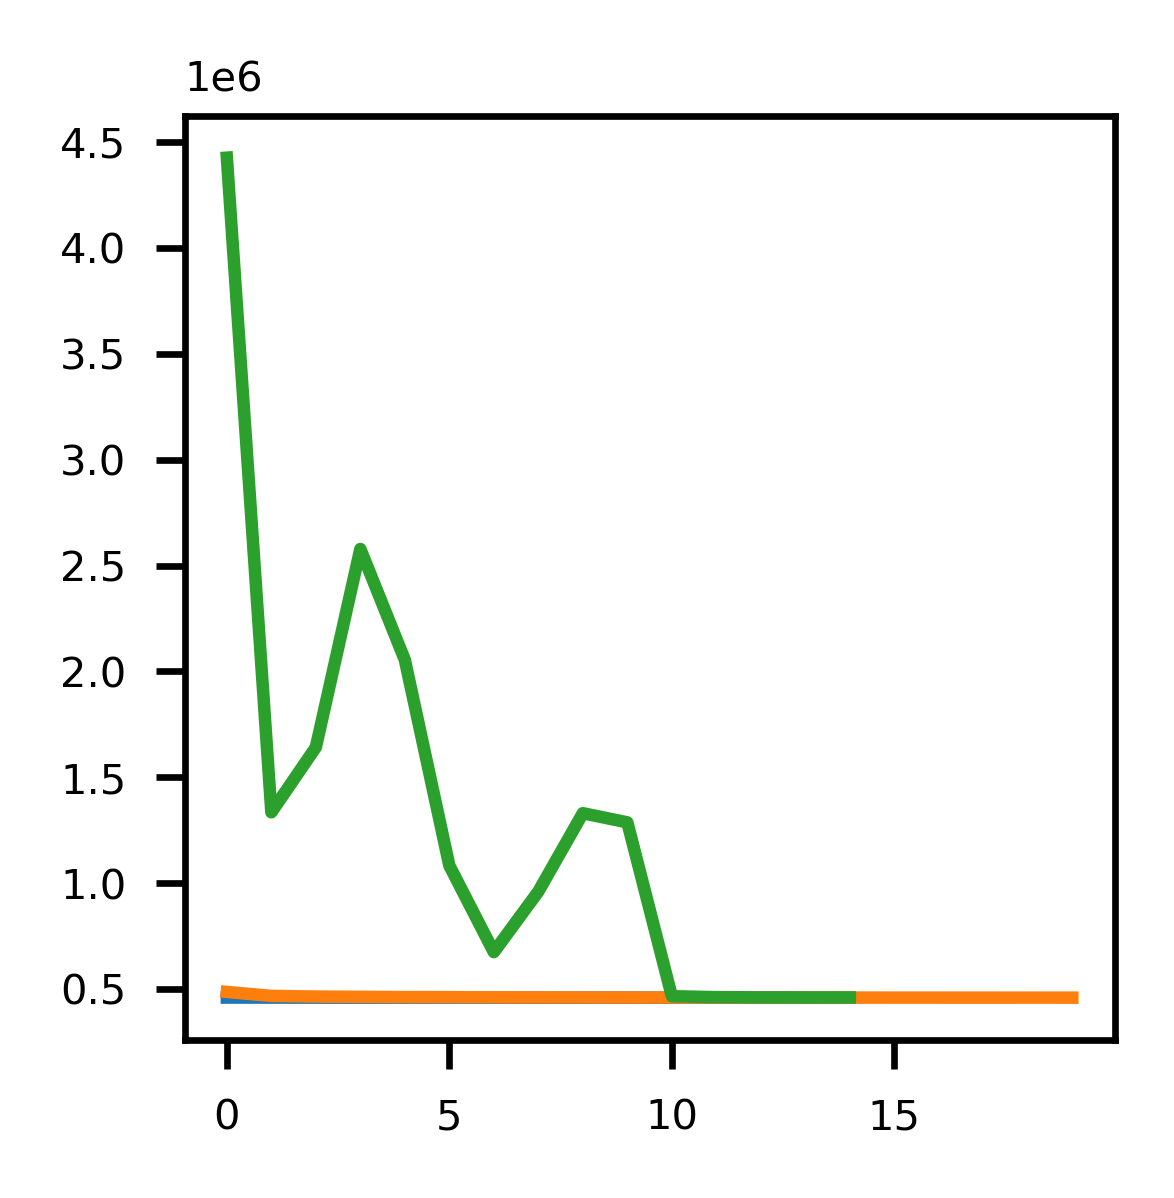

In [84]:
plt.plot(losses_adam[-15:])
plt.plot(losses_lbfgs)
plt.plot(losses_combo)
# plt.semilogy()

SlowGPFA(
  (net): Linear(in_features=5, out_features=168, bias=True)
)

In [54]:
ix=50

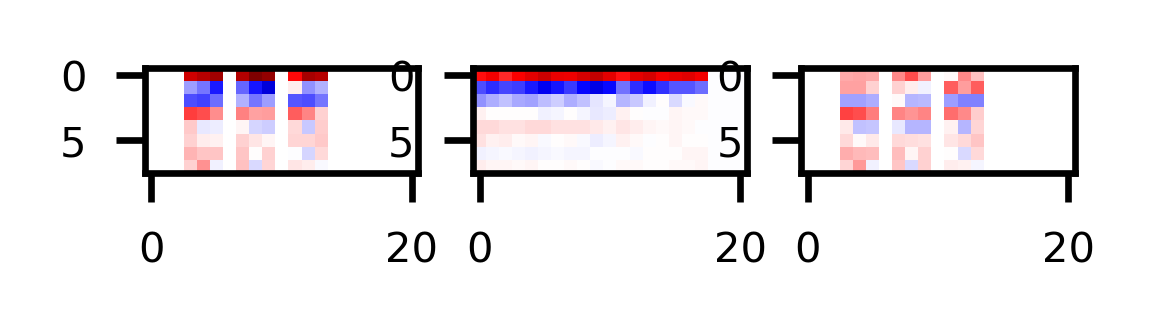

In [55]:
with subplots(ncols=3) as (fig, (aa, ab, ac)):
    xx = X[ix].reshape(8,-1).numpy(force=True)
    yy = gpfa(t[ix:ix+1].cpu())[0].reshape(8,-1).numpy(force=True)
    zz = xx - yy
    vm = np.nanmax(np.abs(xx))
    aa.imshow(xx, vmin=-vm, vmax=vm, cmap=plt.cm.seismic)
    ab.imshow(yy, vmin=-vm, vmax=vm, cmap=plt.cm.seismic)
    ac.imshow(zz, vmin=-vm, vmax=vm, cmap=plt.cm.seismic)

In [56]:
gpfa.inducing_z.mean(0)

tensor([-5.4373, -3.3353, -2.0253, -0.7721,  0.4809], grad_fn=<MeanBackward1>)

In [57]:
gpfa.inducing_z.std(0)

tensor([2.1593, 1.5000, 0.8507, 0.3199, 0.2148], grad_fn=<StdBackward0>)

In [58]:
gpfa.inducing_z.mean(0) / gpfa.inducing_z.std(0)

tensor([-2.5181, -2.2235, -2.3808, -2.4133,  2.2386], grad_fn=<DivBackward0>)

Text(0.5, 0, 'time (inducing points)')

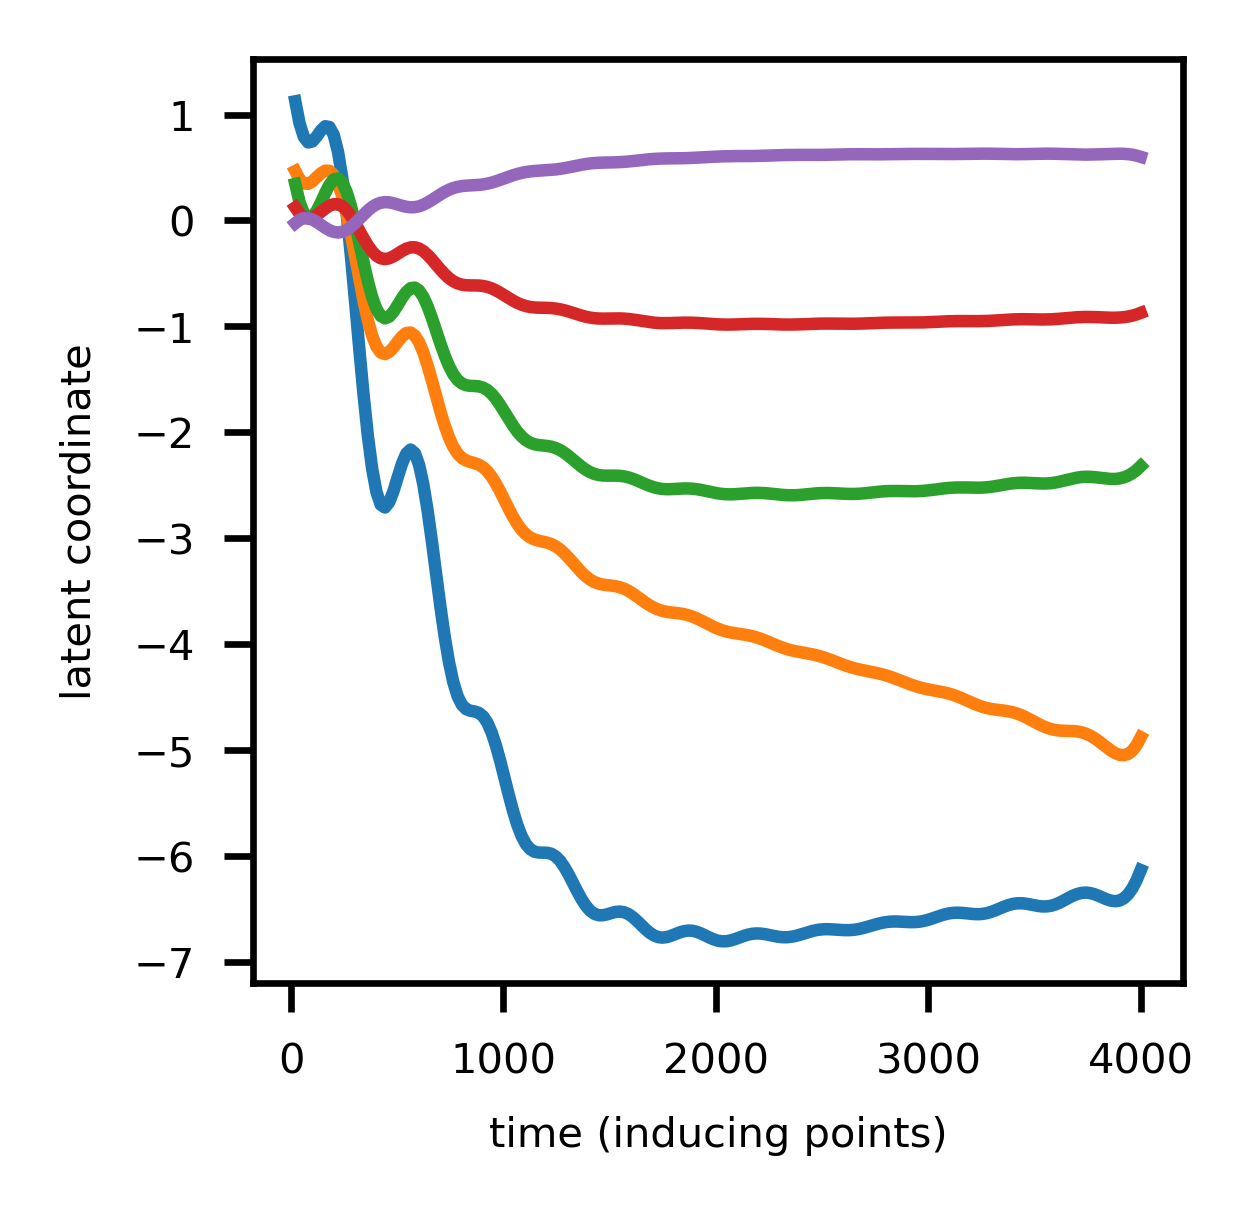

In [59]:
plt.plot(
    gpfa.inducing_times.numpy(force=True),
    gpfa.inducing_z.numpy(force=True),
)
plt.ylabel('latent coordinate')
plt.xlabel('time (inducing points)')

In [734]:
pipeline = torch.load(sub_st.parent_h5_path.parent / "subtraction_models" / "featurization_pipeline.pt")
tpca = pipeline.transformers[0]
tpca.channel_index = torch.from_numpy(gmm.data.wf_channel_index)

from copy import deepcopy
tpca2 = deepcopy(tpca)
tpca2.channel_index = torch.from_numpy(gmm.data.cluster_channel_index)
nc_clust = gmm.data.cluster_channel_index.shape[1]

In [735]:
mc = gmm.main_channels[uid]

In [736]:
preds = gpfa.net(gpfa.inducing_z).numpy(force=True)
recons = tpca2.inverse_transform(torch.from_numpy(preds.reshape(-1,8,nc_clust)), torch.full((len(preds),), mc))

In [737]:
amps = np.nanmax(recons.numpy().ptp(1), 1)

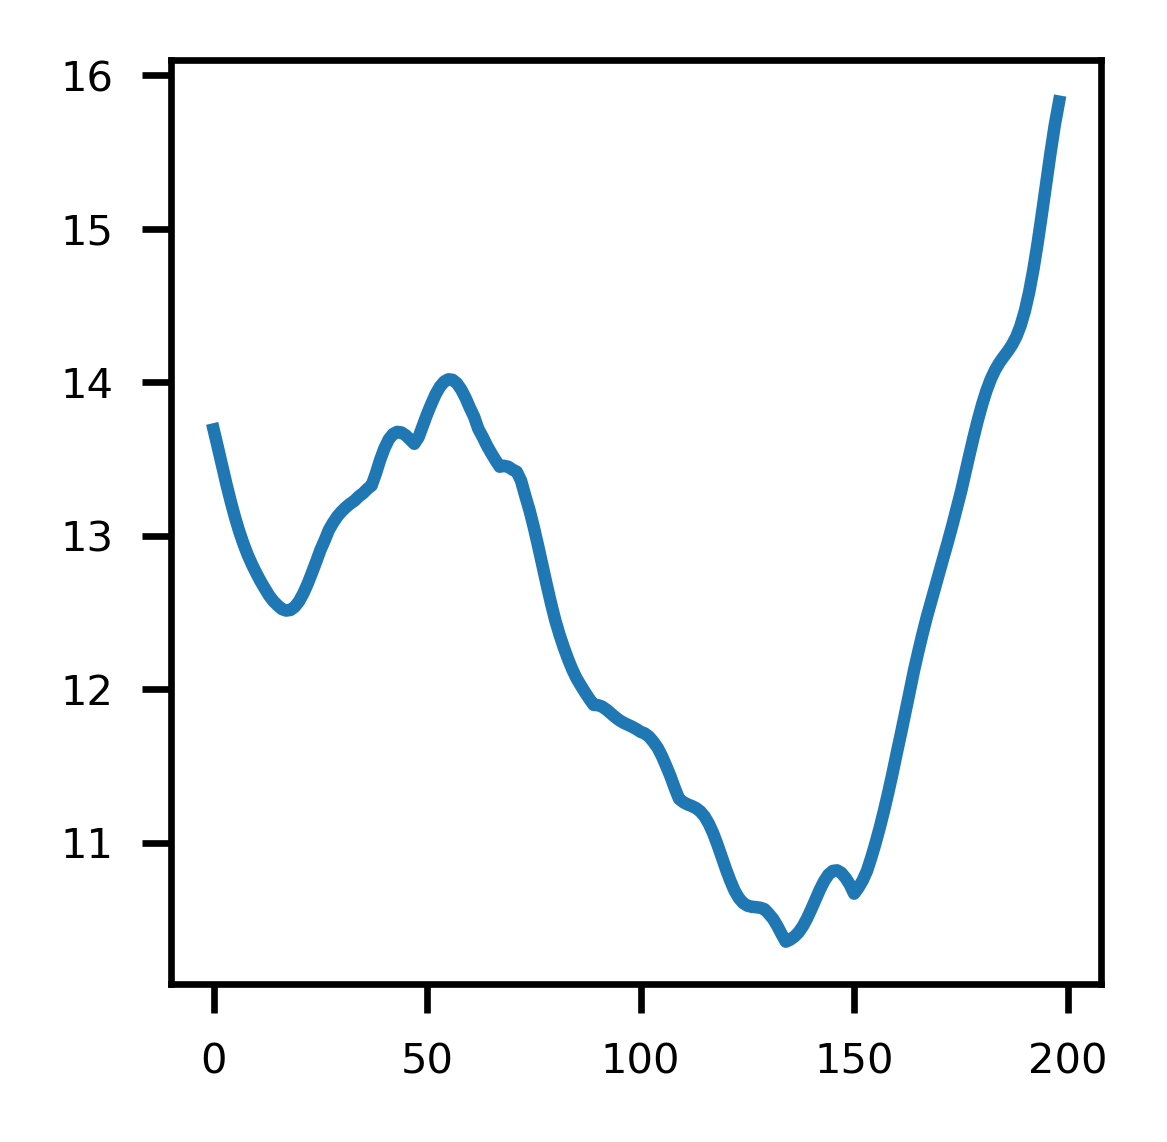

In [738]:
plt.plot(amps);

In [739]:
recon_wf = tpca2.inverse_transform(X.reshape(len(X), 8, -1).cpu(), torch.full(X.shape[:1], mc))

In [740]:
rwf_amps = np.nanmax(recon_wf.numpy().ptp(1), 1)

In [741]:
rwf_amps.shape

(4096,)

In [742]:
t.shape

torch.Size([4096])

Text(0.5, 1.0, 'unit wf amplitude over time')

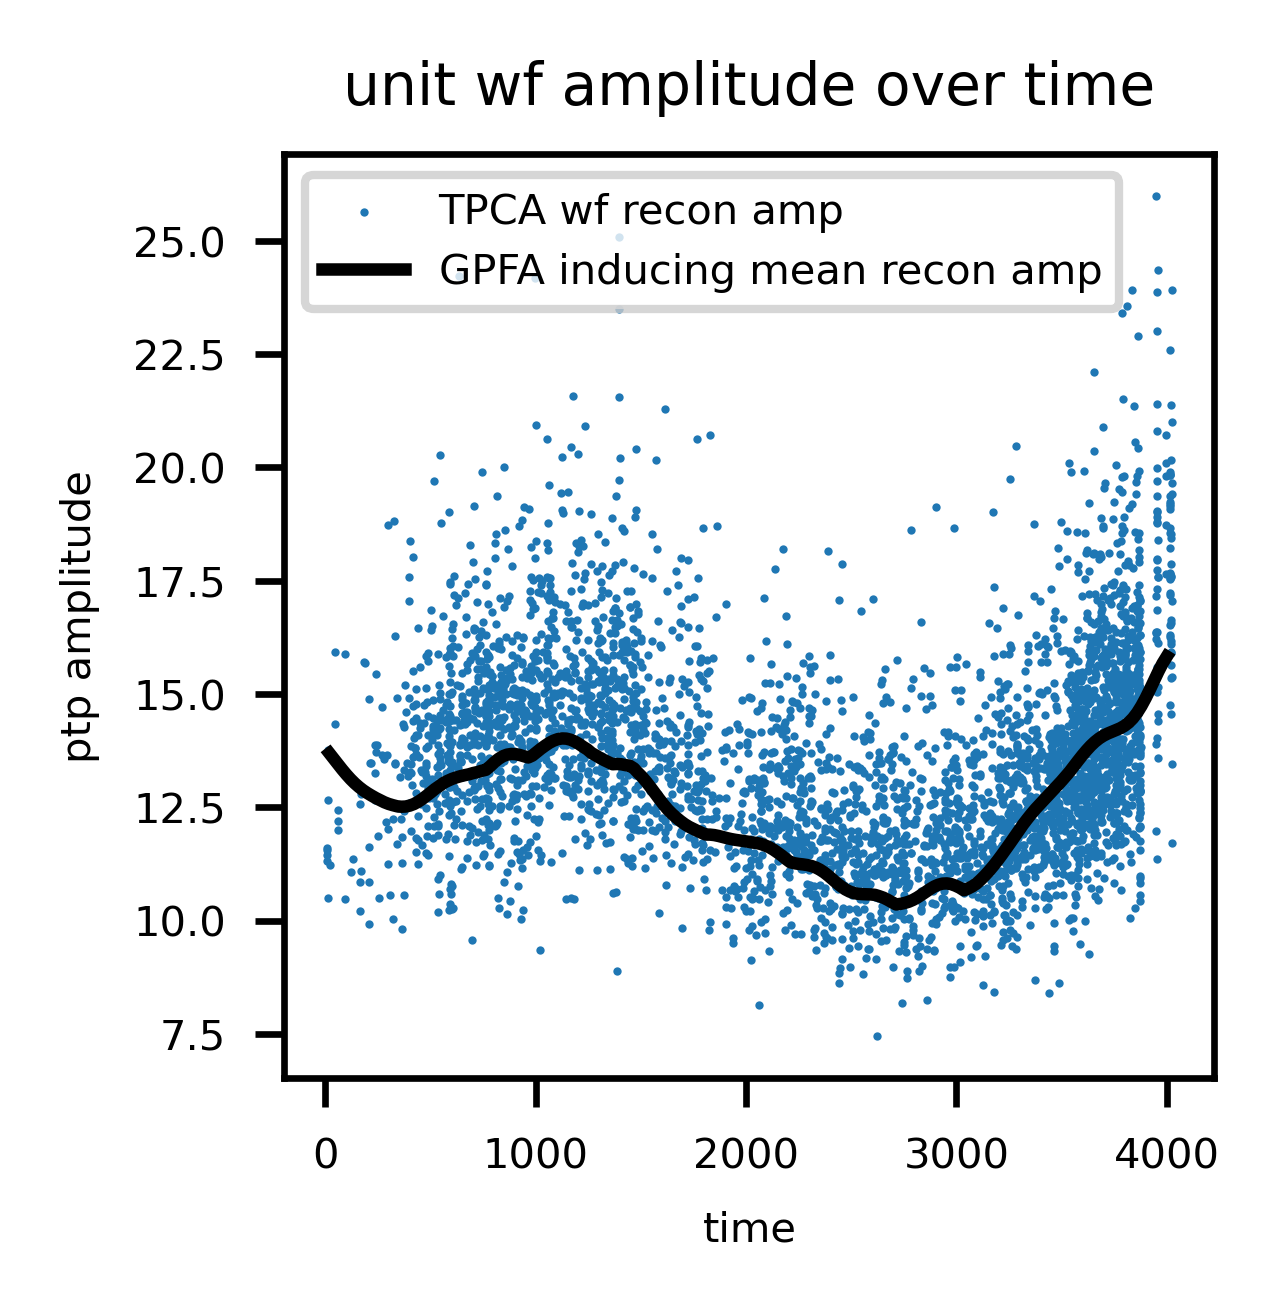

In [743]:
plt.scatter(t.numpy(force=True), rwf_amps, s=1, lw=0, label="TPCA wf recon amp")
plt.plot(gpfa.inducing_times.numpy(force=True), amps, color="k", label="GPFA inducing mean recon amp");
plt.legend()
plt.ylabel('ptp amplitude')
plt.xlabel('time')
plt.title('unit wf amplitude over time')

In [53]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that. Here we are using a grid that has the same number of points as the training data (a ratio of 1.0). Performance can be sensitive to this parameter, so you may want to adjust it for your own problem on a validation set.
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(),
                grid_size=grid_size,
                num_dims=1,
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

mu = torch.nn.Linear(1, X.shape[1])
train_y = mu(

likelihood = gpytorch.likelihoods.GaussianLikelihoodWithMissingObs()
model = GPRegressionModel(train_x, train_y, likelihood)

In [54]:
model

GPRegressionModel(
  (likelihood): GaussianLikelihoodWithMissingObs(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): GridInterpolationKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [ ]:
smoke_test = True
training_iterations = 2 if smoke_test else 30


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(
    [mu.parametes(), model.parameters()],
    lr=0.1,
)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    train_y
    print(f"{output.mean.shape=}")
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

In [42]:
X.shape

torch.Size([1, 4096, 168])